In [21]:
#importamos las librerías generales a utilizar
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


#creamos función para abrir .txt
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        if 'netscience' in nombre_archivo:
            columna=linea.split(',' and ';')
        else:
            columna=linea.split()
        columna = [columna[0],columna[1]]
        data.append(columna)
    return data


### Inciso(a)

In [76]:

redes = {'Y2H': './data/yeast_Y2H.txt', 
         'Sistema Electrico': './data/power_enlaces.txt',
         'Papers': './data/netscience_edgelist.txt',
         'Internet': "./data/as-22july06_edgelist.txt"
         }


def info_red(red):
    nombre, extension = os.path.splitext(red)
    if extension != '.txt':
        Red = nx.read_gml('./data/as-22july06.gml')
    else:
        lista_de_enlaces = abrir_txt(red)
        Red = nx.Graph()
        Red.add_edges_from(lista_de_enlaces)
    Grafo = Red
    Grados = Red.degree()
    return Grafo,Grados

def distribucion_grado_normal(lista_grados):
    
    hist,binedges = np.histogram(lista_grados,density=True,bins=max(lista_grados))
    bincenters = np.round(np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0))
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]
    
def cumulative_binning(lista_grados):
    lista_grados= np.flip(np.sort((lista_grados)))
    ranking = np.arange(1,len(lista_grados)+1)
    pk = ranking/len(ranking)                  
    return lista_grados,pk
    
     

In [59]:
grados_dict = {}
for i, red in enumerate(redes.keys()):
    Grafo, Grados = info_red(redes[red])
    lista_grados= [val for (node, val) in Grados]
    grados_dict[red] = lista_grados

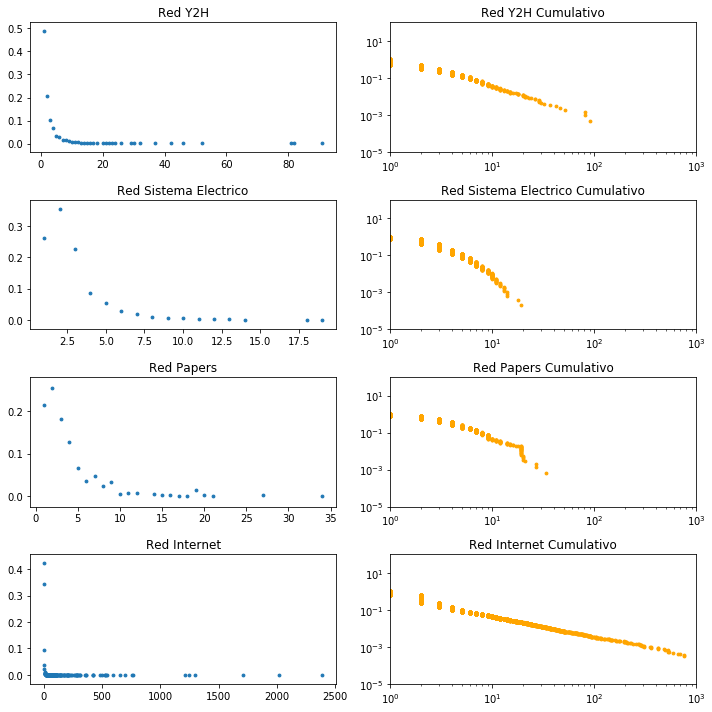

In [78]:
fig, axes = plt.subplots( nrows=4,ncols=2, figsize=(10, 10))

for i,red  in enumerate(redes.keys()):
    lista_grados = grados_dict[red]
    
    #plot distribucion regular
    x1,y1 = distribucion_grado_normal(lista_grados)
    axes[i,0].scatter(x1,y1,s=8)
    axes[i,0].set_title(f"Red {red}")
        
    #plot distribucion cumulativa
    x2,y2 = cumulative_binning(lista_grados)
    axes[i,1].scatter(x2,y2,color='orange',s=8)
    axes[i,1].set_title(f"Red {red} Cumulativo")
    axes[i,1].set_yscale("log")
    axes[i,1].set_xscale("log")
    axes[i,1].set_xlim(10**0,10**3)
    axes[i,1].set_ylim(10**-5,10**2)
plt.tight_layout()
        


### Inciso(b)
Discuta cuál o cuáles casos se ajustan mejor a una ‘power law’, donde la probabilidad de
que un nodo tenga un dado grado k está dada por la ecuación: Pk = Ck−γ


### Inciso(c)
Diga si encuentra algún efecto de borde dado por el tamaño finito de las redes, y para cuáles
redes es más o menos apreciable

se puede apreciar un efecto de borde pronunciado en las redes de Sistema Electrico y de los Papers. Para poder discernir el $\gamma$ se linealiza esta funcion de distribucion.
Lo que voy a hacer es redefinir $P_{k}$ para esta red y mostrar el regimen lineal a partir de la distribucion $P_{k}'$.

Para una red con efectos de borde tenemos que:
$ p_{k} = a(k+k_{sat})^{-\gamma}e^{-\frac{k}{k_{cut}}}$.

Multiplicando por $e^{\frac{k}{k_{cut}}}$ en cada lado definimos pk':
$p_{k}' = p_{k}e^{ \frac{k}{k_{cut}}}= a(k+k_{sat})^{-\gamma}$


(0.01, 10)

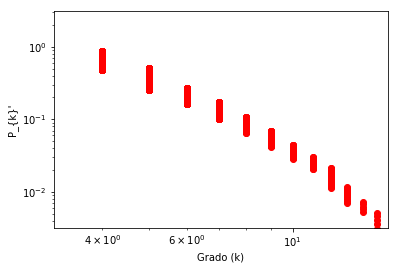

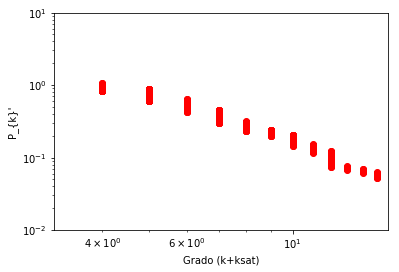

In [89]:
def pk_prima(lista_grados,kcut):
    k,pk = cumulative_binning(lista_grados)
    pk_p = np.array(pk)*np.exp(np.array(k)/ kcut)

    return np.array(k) , pk_p

#ploteamos la nueva funcion de distribucion del grafo Sistema Electrico

ksat = 2 #definimos k-sat a ojo
kcut = 14 #lo mismo para k-cut
k,pk_p =  pk_prima(grados_dict['Sistema Electrico'],kcut)
plt.figure()
plt.scatter(k+ksat,pk_p,color = 'red')
plt.yscale("log")
plt.xscale("log")
plt.ylabel("P_{k}'")
plt.xlabel('Grado (k)')
plt.xlim(10**0.5,10**1.2)
plt.ylim(10**-2.5,10**0.5)

#ploteamos la nueva funcion de distribucion del grafo Papers

ksat = 3 #definimos k-sat a ojo
kcut = 20 #lo mismo para k-cut
k,pk_p =  pk_prima(grados_dict['Papers'],kcut)
plt.figure()
plt.scatter(k+ksat,pk_p,color = 'red')
plt.yscale("log")
plt.xscale("log")
plt.ylabel("P_{k}'")
plt.xlabel('Grado (k+ksat)')
plt.xlim(10**0.5,10**1.2)
plt.ylim(10**-2,10**1)
 
    

Una vez que encontramos esta distribución con una regimen lineal, la podemos someter a las estimaciones de $\gamma$ con las otras distribuciones.

### Inciso(d)

Para ajustar el parámetro $\gamma$ utilizaremos la estimación de parámetros del modelo estadístico Maximum-likelihood estimation (MLE). 
Comenzaremos visualizando los datos con un bineado logarítmico que nos permite apreciar el régimen lineal generado por el binneado y ajustar correctamente el parámetro $\gamma$. 
Aplicaremos este modelo estadístico sólo para la distribución la red de internet (NetScience). Para las de Papers y el sistema Eléctrico utilizaremos la distribución Pk' que calculamos en el inciso c.

ver: puesto que son las que presentan una distribución con un rango dos órdenes mayor que las otras y además no presentan efectos de borde.

Para estimar la cantidad de bins para el bineado logaritmico utilizaremos la regla de Scott$^{[1]}$:
(https://en.wikipedia.org/wiki/Histogram#Scott%27s_normal_reference_rule)

El razonamiento es el siguiente: 
Commo los datos estan bien aproximados por una distribucion logo-normal, al utilizar bines logarítmicos los datos van a tener una distribución aproximadamente normal. Asi que uso Scott's rule que minimiza el promedio 
From trying different bin sizes I know that my data is well approximated by a log normal distribution. Choosing log bins transforms my data into approximately normally distributed data. From the wiki article I take that Scott's rule minimizes the mean squared error of the density estimate.

[1] Scott, David W. (1979). “On optimal and data-base
d histograms”. Biometricka 66 (3): 605-610

(3.162277660168379e-06, 3.1622776601683795)

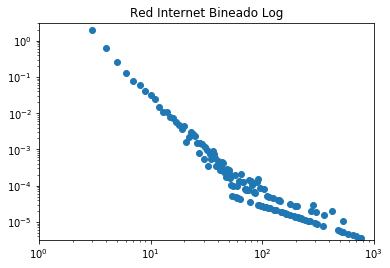

In [25]:
from astropy.stats import scott_bin_width


def log_binning(lista_grados):
    
    #estimo los bins
    ancho_medio, binedges_medio = scott_bin_width(lista_grados,return_bins=True)
    num_bins = int(max(lista_grados)/ancho_medio)
    espaciado_log = np.logspace(0, 4, endpoint=True, base=10,num=num_bins)
    
    hist,binedges = np.histogram(lista_grados,espaciado_log,density=True)
    bincenters = np.round(np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0))
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]


#plot bineado logaritmico
x,y = log_binning(grados_dict['Internet'])
plt.figure()
plt.scatter(x,y)
plt.title(f"Red Internet Bineado Log")
plt.yscale("log")
plt.xscale("log")
plt.ylabel('P_{k}')
plt.xlabel('Grado (k)')
plt.xlim(10**0,10**3)
plt.ylim(10**-5.5,10**0.5)

Este método para estimar la cantidad de bines no resultó óptimo ya que predijo más bines de los necesario.
Utilizaremos la función devuelta pero con un bineado según la definición de un espaciado logarítmico:
    $b_{i} = b_{i-1} + 2^{i}$

[0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095]


(3.1622776601683795e-09, 3.1622776601683795)

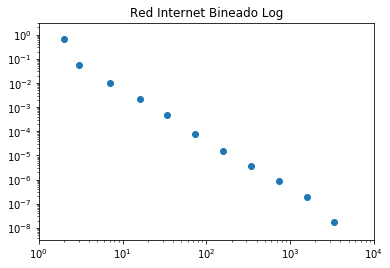

In [28]:

def log_binning_2(red):
    b = [0]
    i=0
    
    while b[-1] <= max(lista_grados):
        bi = b[-1] + 2**i
        b.append(bi)
        i += 1
    print(b)  
    num_bins = len(b)
    espaciado_log = np.logspace(0, 4, endpoint=True, base=10,num=num_bins)
    
    hist,binedges = np.histogram(lista_grados,espaciado_log,density=True)
    bincenters = np.round(np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0))
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]


#plot bineado logaritmico
x,y = log_binning_2(grados_dict['Internet'])
plt.figure()
plt.scatter(x,y)
plt.title(f"Red Internet Bineado Log")
plt.yscale("log")
plt.xscale("log")
plt.ylabel('P_{k}')
plt.xlabel('Grado (k)')
plt.xlim(10**0,10**4)
plt.ylim(10**-8.5,10**0.5)


Ajusto para ver si se cumplen las leyes de potencia para cada red:
$p(k) = Ck^{-\gamma}$.
Con el bineado logaritmico me queda:
$C = (\gamma - 1) K_{min}^{(\gamma-1)}$.
Donde $K_{min}$ es el k que maximiza la probabilidad L:
$ L(k|\gamma) = \prod_{i=1}^{N} p(k) = \prod_{i=1}^{N} \frac{\gamma -1}{K_{min}} (\frac{k_i}{K_{min}})^{-\gamma} $


[0, 1, 3, 7, 15, 31, 63, 127, 255, 511, 1023, 2047, 4095]


Text(0.5, 1.0, 'Red Internet')

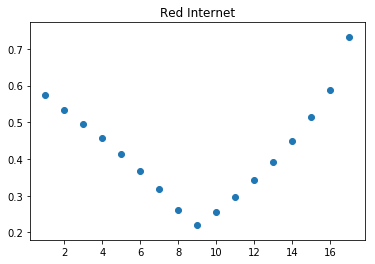

In [101]:


def gamma(N,k,kmin):
    return 1 + N * 1/(np.sum(np.log(k/(kmin-0.5))))

def L_real(pk):
    lista_L = []
    for i in range(len(pk)):
        L_i = np.prod(pk[0:i+1])
        lista_L.append(L_i)
    return np.array(lista_L)

def L(N,k,kmin):
    lista_L = []
    for i in k:
        L_i = np.prod(((gamma(N,k,kmin)-1)/kmin)*((i/kmin)**(-gamma(N,k,kmin))))
        lista_L.append(L_i)
    return np.array(lista_L)

#esta funcion es para probar distintos kmin y ver cual kmin maximiza la prob
def D_max(N,k,kmin):
    L_aproximacion = L(N,k,kmin)
    L_datos = L_real(pk)
    return np.max(np.absolute(L_datos - L_aproximacion))
    
#me creo un dict en donde van a estar los Kmin en funcion de D_max
Kmin = {}
k,pk = log_binning_2(grados_dict[red])
N = len(k)
Ds = []
kmin = range(1,18)
for j in kmin:
    D = D_max(N,k,j)
    Ds.append(D)   
Kmin[red] = kmin[Ds.index(min(Ds))]

#ploteo
plt.scatter(kmin,Ds)
plt.title(f"Red {red}")

    

Busco el $K_min$ que minimiza a la función D y utilizo ese valor para estimar el valor $\gamma$


In [102]:
print(f"El Kmin de la red es {Kmin['Internet']} ")
print(f"El gamma estimado es {np.round(gamma(N,k,Kmin['Internet']),3)}") 
#falta el error, que asumo que es la expansion del error de todas la funcioncitas. Voy a ver si con el fitteo de igraph consigo algo

El Kmin de la red es 9 
El gamma estimado es 1.463


Ahora pasamos a averiguar las $\gamma$ de las funciones de distribucion $P_{k}'$ calculados en el inciso c.
Para eso hacemos ajustamos la función sabiendo que $p_{k}' = p_{k}e^{ \frac{k}{k_{cut}}}= a(k+k_{sat})^{-\gamma}$.


In [98]:
from scipy.optimize import curve_fit

def pk_prima_real_e(k,a,gama):
    return a*((k+14)**(-gama))

def pk_prima_real_p(k,a,gama):
    return a*((k+20)**(-gama))

k_electrico,pk_p_electrico =  pk_prima(grados_dict['Sistema Electrico'],14)  
k_papers,pk_p_papers =  pk_prima(grados_dict['Papers'],20)

param_electrico, param_cov_electrico = curve_fit(pk_prima_real_e,k_electrico,pk_p_electrico, p0=[2,1.5])
param_papers, param_cov_papers = curve_fit(pk_prima_real_p,k_papers,pk_p_papers, p0=[2,1.5])

print(f"El gamma estimado de la red Sistema Electrico es {np.round(param_electrico[1],3)}+-{np.round(np.sqrt(param_cov_electrico[1][1]),3)}")
print(f"El gamma estimado de la red Papers es {np.round(param_papers[1],3)}+-{np.round(np.sqrt(param_cov_papers[1][1]),3)}")

El gamma estimado de la red Sistema Electrico es 6.91+-0.043
El gamma estimado de la red Papers es 6.641+-0.053
